### PUI_Extra Credit 
#### Yuan Lai


##Spatial Homogeneity of NYC Neighborhoods
 <Yuan Lai, https://github.com/ylurban/PUI2015_ylai, yl3250>


###Problem Description: 
Socio-spatial inequality in NYC is a long time discussion regarding city planning, economic development and social justice. This project aims to cross check spatial and social homogeneity to better understand socio-spatial characters of different neighborhoods in NYC. 

###Data: 
The major datasets include PLUTO data on building information and U.S. Census data on demographic data. 

###Analysis: 
By data cleaning, filtering, and aggregation, each neighborhood will be assign value based on it social-spatial homogeneity. The study focuses on the features’ correlation and spatial autocorrelation of neighborhoods. 

###References: 
There are previous studies focusing on social-spatial pattern correlation in Paris and Israel by using data analysis and GIS visualization. However, few study focused on New York City, especially through PLUTO data. 


###Deliverable: 
The final output will be a report with statistical conclusions and data visualization showing the degree of social-spatial homogeneity in New York City. This information would be valuable for both public agencies and private sectors to better evaluate neighborhood characters and real estate development, and better informed risk management and capital planning. Especially, this study will provide a metric to balance property investment and social good for the City. 

###Progress:
So far I have calculated the building, lot, and land use variety score by zip code and normalized them for future calculation. I also calculated social diversity by zip code by using the percentage of foreign-born residents. Later I will visualize the data on NYC map.


In [1]:
import pandas as pd
import numpy as np
import zipfile 
import pandas as pd
import glob
import urllib2
import json
import pylab as pl
import sklearn.cluster
import os
import scipy 
from math import sqrt
from scipy.stats.stats import pearsonr
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist


%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
import geopandas as gp
fname = 'nyc-zip-code-tabulation-areas-polygons.geojson'
nyc = gp.read_file(fname)

In [30]:
MN = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/nyc_pluto_15v1-2/Mn.csv')
BK = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/nyc_pluto_15v1-2/BK.csv')
BX = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/nyc_pluto_15v1-2/BX.csv')
QN = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/nyc_pluto_15v1-2/QN.csv')
SI = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/nyc_pluto_15v1-2/SI.csv')
NYC = pd.concat([MN,BK,BX,QN,SI])
NYC.shape

(859464, 83)

In [31]:
NYC = NYC[['ZipCode','AllZoning1', 
       'BldgClass', 'BldgArea', 'LotArea','NumFloors', 
        'BldgFront',
       'BldgDepth', 'IrrLotCode']]
NYC.head()

,ZipCode,AllZoning1,BldgClass,BldgArea,LotArea,NumFloors,BldgFront,BldgDepth,IrrLotCode
0,10004,R3-2/GI,Y4,2725731,7736692,0,0,0,N
1,10004,R3-2,P7,541886,541886,0,0,0,Y
2,10004,R3-2,Z9,603130,2764190,0,0,0,N
3,10004,ZNA,U0,0,0,0,0,0,N
4,10004,ZNA,U0,0,0,0,0,0,N


In [34]:
building_height = NYC.groupby(['ZipCode'])['NumFloors'].std()
building_height.head()

ZipCode
10307    0.598419
11207    1.238357
11208    0.713695
11416    0.250000
         0.253815
Name: NumFloors, dtype: float64

In [37]:
zoning = NYC.groupby(['ZipCode'])['LotArea'].std()
zoning.head()

ZipCode
10307       3592.293443
11207       2291.513827
11208      46528.487686
11416        641.722876
         3239742.971295
Name: LotArea, dtype: float64

In [39]:
front = NYC.groupby(['ZipCode'])['BldgFront'].std()
front.head()

ZipCode
10307    11.356929
11207     9.910998
11208    15.473335
11416     1.500000
         13.773175
Name: BldgFront, dtype: float64

In [40]:
depth = NYC.groupby(['ZipCode'])['BldgDepth'].std()
depth.head()

ZipCode
10307    16.586699
11207    20.789340
11208    19.401049
11416     4.500000
         13.599705
Name: BldgDepth, dtype: float64

In [51]:
NYC['IrrLotCode'] = pd.Categorical(NYC.IrrLotCode).codes
irr = NYC.groupby(['ZipCode'])['IrrLotCode'].std()
irr.head()

ZipCode
10307    0.359367
11207    0.262527
11208    0.346272
11416    0.000000
         0.659871
Name: IrrLotCode, dtype: float64

In [109]:
df = pd.concat([building_height,front,depth,irr],axis=1)
df.head()

,NumFloors,BldgFront,BldgDepth,IrrLotCode
ZipCode,,,,
10307,0.598419,11.356929,16.586699,0.359367
11207,1.238357,9.910998,20.789340,0.262527
11208,0.713695,15.473335,19.401049,0.346272
11416,0.250000,1.500000,4.500000,0.000000
,0.253815,13.773175,13.599705,0.659871


In [115]:
#Normailization:
for i in range(0, (len(df)-1)):
    df['NumFloors'][i] = (df['NumFloors'][i]-min(df['NumFloors']))/(max(df['NumFloors'])-min(df['NumFloors']))
    df['BldgFront'][i] = (df['BldgFront'][i]-min(df['BldgFront']))/(max(df['BldgFront'])-min(df['BldgFront']))
    df['BldgDepth'][i] = (df['BldgDepth'][i]-min(df['BldgDepth']))/(max(df['BldgDepth'])-min(df['BldgDepth']))
    df['IrrLotCode'][i] = (df['IrrLotCode'][i]-min(df['IrrLotCode']))/(max(df['IrrLotCode'])-min(df['IrrLotCode']))
   
df['sum']= df['NumFloors']+df['BldgFront']+df['IrrLotCode']  
for i in range(0, (len(df)-1)):
    df['sum'][i] = (df['sum'][i]-min(df['sum']))/(max(df['sum'])-min(df['sum']))

In [116]:
df.head()

,NumFloors,BldgFront,BldgDepth,IrrLotCode,sum
ZipCode,,,,,
10307,0.000000,0.000072,0.000029,0.544602,0.032117
11207,0.045713,0.000086,0.000158,0.397846,0.026106
11208,0.024037,0.000139,0.000147,0.524757,0.032370
11416,0.004880,0.000004,0.000031,0.000000,0.000000
,0.005233,0.000132,0.000103,1.000000,0.059801


In [135]:
del df['NumFloors']
del df['BldgFront']
del df['BldgDepth']
del df['IrrLotCode']

In [136]:
df['sum'].describe()

count    193.000000
mean       0.005181
std        0.048703
min        0.000000
25%        0.001206
50%        0.001476
75%        0.001977
max        0.678209
Name: sum, dtype: float64

In [137]:
def normalize(lst):
    s = sum(lst)
    return map(lambda x: float(x)/s, lst)

In [138]:
df['sum'] = normalize(df['sum'])
df['sum'].describe()

count    193.000000
mean       0.005181
std        0.048703
min        0.000000
25%        0.001206
50%        0.001476
75%        0.001977
max        0.678209
Name: sum, dtype: float64

In [241]:
pop = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/NYC GIS/SimplyMap_Shapefiles_2015-12-15_19_01_13d4fb1b201320bda44baeddd8b54df555/PoP.csv')
pop['pop']=100-pop['pop']
for i in range(0, (len(pop)-1)):
    pop['pop'][i] = (pop['pop'][i]-min(pop['pop']))/(max(pop['pop'])-min(pop['pop']))
pop.head()

/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,zip,pop
0,10001,0.210245
1,10002,0.424290
2,10003,0.196511
3,10004,0.266158
4,10005,0.273472


In [242]:
df['zip'] = df.index.values

In [243]:
print df.shape
print pop.shape

(198, 2)
(211, 2)


In [244]:
#df.to_csv('df.csv')
pop=pd.read_csv('pop.csv')
df = pd.read_csv('df.csv')

In [245]:
data = pd.merge(df,pop,on = 'zip')
data.shape

(189, 3)

In [256]:
data.index = data['zip']
del data['zip']
#del data['sum']
data.head()

,sum,pop,log_sum
zip,,,
10307,0.001296,0.100214,-6.648760
10307,0.001067,0.100214,-6.843036
11207,0.001053,0.319032,-6.855985
11207,0.001588,0.319032,-6.445455
11208,0.001306,0.378882,-6.640900


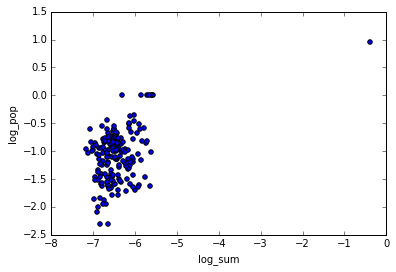

In [261]:
import matplotlib.pyplot as plt
import numpy as np



data['log_sum'] = log(data['sum'])
data['log_pop'] = log(data['pop'])

data.plot(kind='scatter', x='log_sum', y='log_pop')

In [263]:
del data['pop']

del data['log_pop']

In [331]:

data.to_csv('data_2.csv')
data = pd.read_csv('data_2.csv')
data.index = data['zip'].values
data.head()

,Unnamed: 0,zip,sum
10307,0,10307,0.001296
10307,1,10307,0.001067
11207,2,11207,0.001053
11207,3,11207,0.001588
11208,4,11208,0.001306


In [341]:
x = data.values

def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

import random

def k_means_clust(data,num_clust,num_iter): 
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print counter
        assignments={}
        
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if euclid_dist(i,j)<min_dist:
                    min_dist = euclid_dist(i,j)
                    closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
                centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    return centroids

At 2 clusters, silhouette score is 0.993579705896
At 3 clusters, silhouette score is 0.667518829645
At 4 clusters, silhouette score is 0.587007404552
At 5 clusters, silhouette score is 0.560666773802
At 6 clusters, silhouette score is 0.546728020858
At 7 clusters, silhouette score is 0.542363429532
At 8 clusters, silhouette score is 0.549675564096


(0.2, 1)

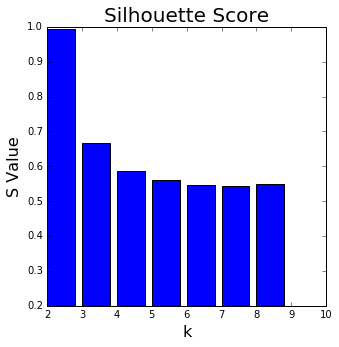

In [342]:
# Calculate S to evaluate the performance of clustering at different values of k.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

s = np.zeros(8)
for k in range(0,7):
    est = KMeans(n_clusters = k+2, n_init = 100)
    est.fit(data)
    s[k] = silhouette_score(data, est.labels_)
    print('At {0} clusters, silhouette score is {1}'.format(k+2, s[k]))
    
plt.figure(figsize=(5, 5))
plt.bar(range(2, 10), s)
plt.xlabel('k', fontsize = 16)
plt.ylabel('S Value', fontsize = 16)
plt.title('Silhouette Score', fontsize = 20)
plt.ylim(.2, 1)

ValueError: could not convert string to float: sum

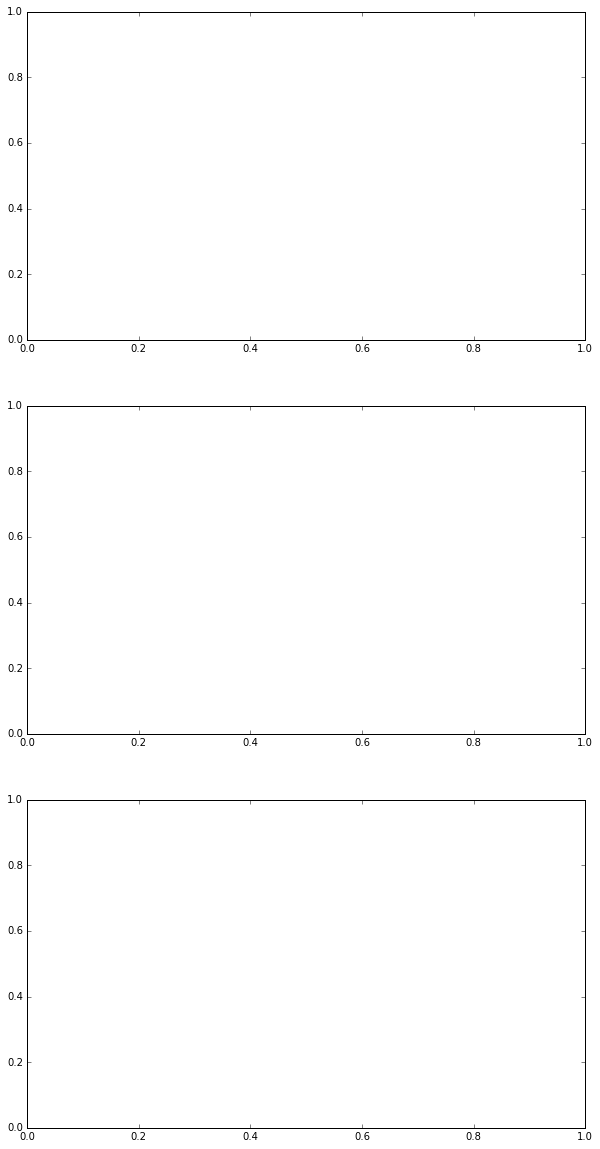

In [345]:
cluster = pd.Series(0)
year = np.arange(2002, 2014, 1).tolist()
zipcode = data.index.tolist()

for i,key in assignments.iteritems():
    for j in key:
        cluster[j] = i
cluster = cluster.sort_index()
mydata = pd.DataFrame({'zip':zipcode,
                       'cluster':cluster})
zips = str(mydata.iloc[i]['zip'])
cluster = mydata.iloc[i]['cluster']

fig = plt.figure(figsize=(10,20))
ax = []
for i in range(len(centroids)):
    ax.append(fig.add_subplot(3,1,i+1)) 
for i in range(len(mydata)):
    cluster = mydata.iloc[i]['cluster']
    ax[cluster].plot(data.iloc[i],'k',alpha=0.3)
for i in range(len(centroids)):    
    ax[i].plot(year,centroids[i],linewidth=10)


map_data_dev = pd.merge(nyc, mydata, left_on = 'postalCode', right_on = 'zip')
map_data_dev.plot(column='cluster', figsize=(10,10))

In [ ]:
mydata.head()
mydata['zip'] = str(mydata['zip'])

In [340]:
map_data_dev = pd.merge(nyc, mydata, left_on = 'postalCode', right_on = 'zip')
map_data_dev.plot(column='cluster', figsize=(10,10))

ValueError: min() arg is an empty sequence